In [1]:
import os
import os.path as op
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from pathlib import Path
from scipy.stats import ttest_1samp

### Inspect column names

To fix some errors I made in writing the log files

In [2]:
# root = Path('../data/logs/')
# headers = {}
# for file in root.rglob("*.log"):
#     sub = int(re.findall('sub-(\d{1,2})', file.name)[0])
#     sub_df = pd.read_csv(file)
#     col_names = sub_df.columns.values.tolist()
#     headers[sub] = col_names

# headers = pd.DataFrame.from_dict(headers, orient='index')
# headers = headers.sort_index()

### Load data

In [3]:
# root = Path('../data/logs/')
# df = pd.DataFrame()
# for file in root.rglob("*.log"):
#     sub = int(re.findall('sub-(\d{1,2})', file.name)[0])
#     if sub < 10:
#         continue
#     sub_df = pd.read_csv(file)
#     df = pd.concat([df, sub_df])
# df.to_csv('../data/behavioral_data.csv')
df = pd.read_csv('../data/behavioral_data.csv')
df

,Unnamed: 0,seed,sub_num,block_num,predictable,seq_num,target,n_target_plays,tone_num,freq,mark,is_target,n_targets,response,correct,score
0,0,3902,39,2,True,1,150,3,1,110,21,0,16,16,2,1
1,1,3902,39,2,True,1,150,3,2,110,21,0,16,16,2,1
2,2,3902,39,2,True,1,150,3,3,150,22,1,16,16,2,1
3,3,3902,39,2,True,1,150,3,4,150,22,1,16,16,2,1
4,4,3902,39,2,True,1,150,3,5,210,23,0,16,16,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149291,1087,2403,24,3,True,24,150,2,44,110,21,0,16,16,2,24
149292,1088,2403,24,3,True,24,150,2,45,150,22,1,16,16,2,24
149293,1089,2403,24,3,True,24,150,2,46,150,22,1,16,16,2,24
149294,1090,2403,24,3,True,24,150,2,47,210,23,0,16,16,2,24


In [4]:
# Drop subjects with fewer than 80% EEG trials
BADS = [33, 37]
for bad in BADS:
    df = df[df['sub_num'] != bad]
np.unique(df['sub_num'])

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

## Accuracies

In [5]:
# df_scores = df[df.tone_num == 1] # Get only one trial per sequence to extract the score
# df_scores = df_scores[['sub_num', 'block_num', 'predictable', 'target', 'n_target_plays', 'n_targets', 'response']]
# df_scores['accuracy'] = 1 - abs(df_scores.n_targets - df_scores.response)/df_scores.n_targets
# df_scores = df_scores[df_scores.block_num != 0]
# df_scores.to_csv('../data/accuracy_by_trial.csv')
df_scores = pd.read_csv('../data/accuracy_by_trial.csv')
df_scores

,Unnamed: 0,sub_num,block_num,predictable,target,n_target_plays,n_targets,response,accuracy
0,0,39,2,True,150,3,16,16,1.0000
1,49,39,2,True,110,2,16,16,1.0000
2,98,39,2,True,210,2,16,16,1.0000
3,148,39,2,True,110,2,16,16,1.0000
4,195,39,2,True,110,3,16,16,1.0000
...,...,...,...,...,...,...,...,...,...
3041,149056,24,3,True,110,3,16,15,0.9375
3042,149105,24,3,True,210,1,15,15,1.0000
3043,149150,24,3,True,150,2,16,16,1.0000
3044,149199,24,3,True,210,2,16,16,1.0000


#### Boxplots of accuracy by target

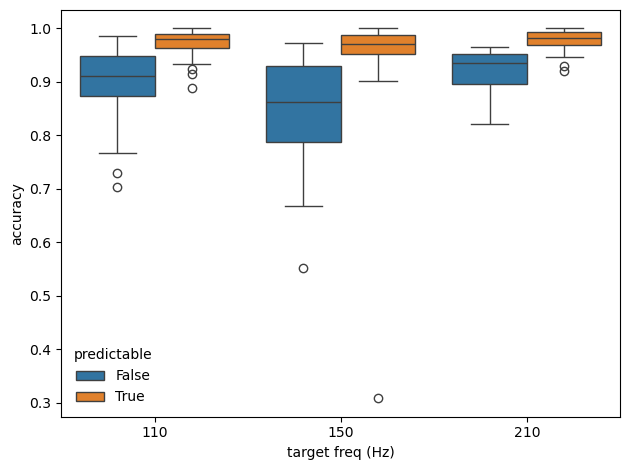

In [6]:
accuracies = df_scores.groupby(['sub_num', 'target', 'predictable'])['accuracy'].mean()
accuracies = pd.DataFrame(accuracies).reset_index()
graph = sns.boxplot(data = accuracies, x = 'target', y = 'accuracy', hue = 'predictable')
graph.set(xlabel = 'target freq (Hz)', ylabel = 'accuracy')
plt.legend(frameon=False, title = 'predictable')
plt.tight_layout()
plt.savefig('../figs/accuracy-by-condition.png')

#### Summary statistics

In [7]:
accuracies_by_sub = df_scores.groupby(['sub_num'], as_index = False)['accuracy'].mean()
print(accuracies_by_sub['accuracy'].describe())

# For predictable blocks
accuracies_by_predictability = df_scores.groupby(['sub_num', 'predictable'], as_index = False)['accuracy'].mean()
print('Predictable')
print(accuracies_by_predictability[accuracies_by_predictability.predictable == True]['accuracy'].describe())
print('Random')
print(accuracies_by_predictability[accuracies_by_predictability.predictable == False]['accuracy'].describe())

# For random blocks by target tone identity
acc_by_pred_and_target = df_scores.groupby(['sub_num', 'target', 'predictable'], as_index = False)['accuracy'].mean()
print('Random, 110 Hz target')
print(acc_by_pred_and_target[(acc_by_pred_and_target.predictable == False) & (acc_by_pred_and_target.target == 110)]['accuracy'].describe())
print('Random, 150 Hz target')
print(acc_by_pred_and_target[(acc_by_pred_and_target.predictable == False) & (acc_by_pred_and_target.target == 150)]['accuracy'].describe())
print('Random, 210 Hz target')
print(acc_by_pred_and_target[(acc_by_pred_and_target.predictable == False) & (acc_by_pred_and_target.target == 210)]['accuracy'].describe())

count    30.000000
mean      0.925305
std       0.043909
min       0.813361
25%       0.909544
50%       0.936842
75%       0.954773
max       0.983871
Name: accuracy, dtype: float64
Predictable
count    30.000000
mean      0.965851
std       0.038961
min       0.790381
25%       0.963124
50%       0.973431
75%       0.985409
max       1.000000
Name: accuracy, dtype: float64
Random
count    30.000000
mean      0.886889
std       0.063067
min       0.705882
25%       0.854095
50%       0.901250
75%       0.938876
max       0.970719
Name: accuracy, dtype: float64
Random, 110 Hz target
count    30.000000
mean      0.900722
std       0.070105
min       0.702535
25%       0.873967
50%       0.911982
75%       0.948892
max       0.985470
Name: accuracy, dtype: float64
Random, 150 Hz target
count    30.000000
mean      0.842367
std       0.101600
min       0.552727
25%       0.787704
50%       0.861850
75%       0.930272
max       0.971980
Name: accuracy, dtype: float64
Random, 210 Hz target


#### Tests

In [18]:
# Repeated Measures ANOVA
from statsmodels.stats.anova import AnovaRM
aov = AnovaRM(
    data = accuracies, 
    depvar = 'accuracy',
    subject = 'sub_num', 
    within = ['target', 'predictable']
)
res = aov.fit()
print(res)

# Pairwise t-tests
from scipy import stats

accuracies_random = accuracies[accuracies.predictable == False]
print(stats.ttest_rel(accuracies_random.accuracy[accuracies_random.target == 110], accuracies_random.accuracy[accuracies_random.target == 150]))
print(stats.ttest_rel(accuracies_random.accuracy[accuracies_random.target == 150], accuracies_random.accuracy[accuracies_random.target == 210]))
print(stats.ttest_rel(accuracies_random.accuracy[accuracies_random.target == 110], accuracies_random.accuracy[accuracies_random.target == 210]))

accuracies_predictable = accuracies[accuracies.predictable == True]
print(stats.ttest_rel(accuracies_predictable.accuracy[accuracies_predictable.target == 110], accuracies_predictable.accuracy[accuracies_predictable.target == 150]))
print(stats.ttest_rel(accuracies_predictable.accuracy[accuracies_predictable.target == 150], accuracies_predictable.accuracy[accuracies_predictable.target == 210]))
print(stats.ttest_rel(accuracies_predictable.accuracy[accuracies_predictable.target == 110], accuracies_predictable.accuracy[accuracies_predictable.target == 210]))

print(stats.ttest_rel(accuracies_predictable.accuracy[accuracies_predictable.target == 110], accuracies_random.accuracy[accuracies_random.target == 110], alternative = 'greater'))
print(stats.ttest_rel(accuracies_predictable.accuracy[accuracies_predictable.target == 150], accuracies_random.accuracy[accuracies_random.target == 150], alternative = 'greater'))
print(stats.ttest_rel(accuracies_predictable.accuracy[accuracies_predictable.target == 210], accuracies_random.accuracy[accuracies_random.target == 210], alternative = 'greater'))


                     Anova
                   F Value Num DF  Den DF Pr > F
------------------------------------------------
target              9.0064 2.0000 58.0000 0.0004
predictable        54.6711 1.0000 29.0000 0.0000
target:predictable  3.0073 2.0000 58.0000 0.0572

TtestResult(statistic=3.712246172534123, pvalue=0.0008686077966293646, df=29)
TtestResult(statistic=-4.815548106594199, pvalue=4.2349233604912294e-05, df=29)
TtestResult(statistic=-1.716401335997676, pvalue=0.09675393745204292, df=29)
TtestResult(statistic=1.1415916397582948, pvalue=0.2629629096416749, df=29)
TtestResult(statistic=-1.4017038874759626, pvalue=0.17161640663672748, df=29)
TtestResult(statistic=-1.6186197620459741, pvalue=0.11635537798660807, df=29)
TtestResult(statistic=6.883062526745176, pvalue=7.299678556892353e-08, df=29)
TtestResult(statistic=4.40091613571135, pvalue=6.673625310989297e-05, df=29)
TtestResult(statistic=8.112991056240393, pvalue=3.0125754773382102e-09, df=29)


#### Label subs by low and high accuracy

In [9]:
accuracies

,sub_num,target,predictable,accuracy
0,10,110,False,0.972077
1,10,110,True,1.000000
2,10,150,False,0.966880
3,10,150,True,0.990476
4,10,210,False,0.953964
...,...,...,...,...
175,41,110,True,1.000000
176,41,150,False,0.952038
177,41,150,True,0.954464
178,41,210,False,0.943769


[2, 4, 6, 7, 9, 11, 13, 15, 20, 21, 22, 23, 25, 26, 28, 31, 32, 34, 36, 37]
[3, 5, 8, 10, 12, 14, 16, 17, 18, 19, 24, 27, 29, 30, 33, 35, 38, 39, 40, 41]


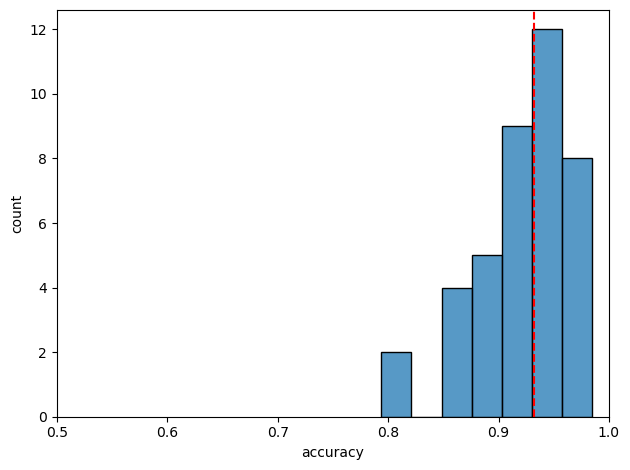

In [19]:
accuracies = pd.read_csv('../data/accuracy_by_sub.csv', index_col = 0)

# Calculate overall accuracies of each subject
accuracies_sub = accuracies.groupby(['sub_num'], as_index = False)['accuracy'].mean()

# Group into low and high subs on median split
med = np.median(accuracies_sub.accuracy)
low_subs = list(accuracies_sub.sub_num[accuracies_sub.accuracy < med])
high_subs = list(accuracies_sub.sub_num[accuracies_sub.accuracy > med])
print(low_subs)
print(high_subs)

# Plot
graph = sns.histplot(accuracies_sub.accuracy)
graph.set_xlim(0.5, 1)
graph.axvline(med, linestyle = 'dashed', color = 'red')
graph.set(xlabel = 'accuracy')
graph.set(ylabel = 'count')
plt.tight_layout()
plt.savefig('../figs/accuracy-hist.png')

# Add group to a column
accuracy_group = []
for sub in accuracies_sub.sub_num:
    if sub in low_subs:
        accuracy_group.append("low")
    elif sub in high_subs:
        accuracy_group.append("high")
accuracies_sub['accuracy_group'] = accuracy_group
accuracies_sub

# Save to df
accuracies_sub.to_csv('accuracies.csv', index = False)

## Target plays

In [11]:
# Clean data
df_plays = df[df.tone_num != 1]
df_plays = df_plays[['sub_num', 'block_num', 'target', 'n_target_plays']]
df_plays = df_plays[df_plays.n_target_plays < 50]
df_plays = df_plays[df_plays.block_num != 0]
df_plays = df_plays[df_plays.block_num != 6]
df_plays = df_plays.dropna()

# Calculate means by sub
df_plays = df_plays.groupby(['sub_num', 'target', 'block_num'])['n_target_plays'].mean()
df_plays = pd.DataFrame(df_plays).reset_index()

df_plays

,sub_num,target,block_num,n_target_plays
0,10,110,1,2.757353
1,10,110,2,3.100897
2,10,110,3,3.353086
3,10,110,4,3.980440
4,10,150,1,4.122222
...,...,...,...,...
355,41,150,4,1.110837
356,41,210,1,1.000000
357,41,210,2,1.000000
358,41,210,3,1.322807


#### Histogram of target plays across subjects

<Axes: xlabel='n_target_plays', ylabel='Count'>

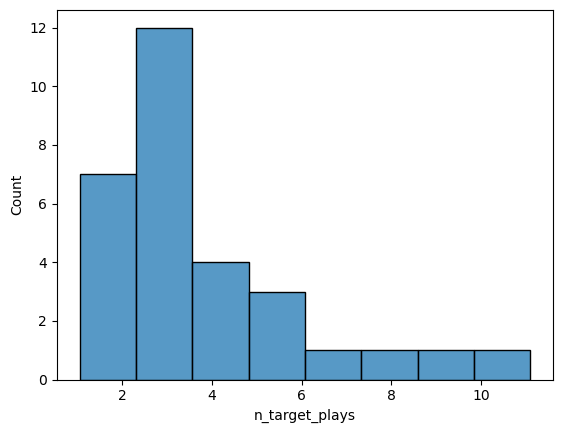

In [12]:
df_plays_hist = df_plays.groupby(['sub_num'])['n_target_plays'].mean()
sns.histplot(df_plays_hist)

#### Boxplots of target plays by target freq and block number

<Axes: xlabel='target', ylabel='n_target_plays'>

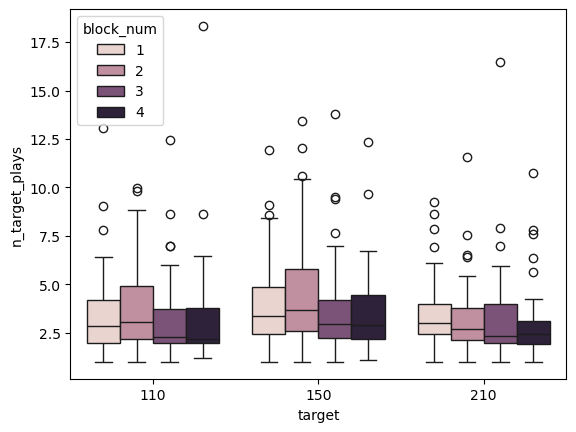

In [13]:
sns.boxplot(data = df_plays, x = 'target', y = 'n_target_plays', hue = 'block_num')

## Accuracy by target identity

In [14]:
accuracies

,sub_num,target,predictable,accuracy
0,2,110,False,0.831356
1,2,150,False,0.786497
2,2,210,False,0.804487
3,3,110,False,0.908541
4,3,110,True,1.000000
...,...,...,...,...
232,41,110,True,1.000000
233,41,150,False,0.952038
234,41,150,True,0.954464
235,41,210,False,0.943769


(0.0, 1.0345887104841938)

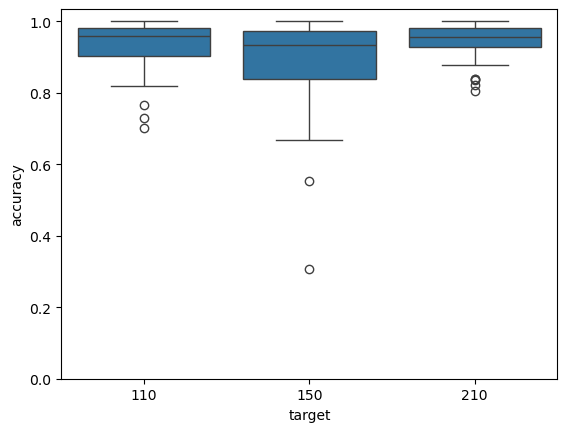

In [15]:
p = sns.boxplot(data = accuracies, x = 'target', y = 'accuracy')
p.set_ylim(0)

## Regressions

In [16]:
accuracies

,sub_num,target,predictable,accuracy
0,2,110,False,0.831356
1,2,150,False,0.786497
2,2,210,False,0.804487
3,3,110,False,0.908541
4,3,110,True,1.000000
...,...,...,...,...
232,41,110,True,1.000000
233,41,150,False,0.952038
234,41,150,True,0.954464
235,41,210,False,0.943769


In [17]:
spectrums = pd.read_csv('spectrums.csv', sep = '\t')
spectrums

,subject,predictable,target,tone,frequency,dB
0,10,True,110,110,0.00000,-8.731832
1,10,True,110,110,4.99002,-8.800200
2,10,True,110,110,9.98004,-8.689376
3,10,True,110,110,14.97006,-7.458321
4,10,True,110,110,19.96008,-8.211036
...,...,...,...,...,...,...
144571,41,False,210,210,1227.54491,-2.851024
144572,41,False,210,210,1232.53493,-2.627593
144573,41,False,210,210,1237.52495,-0.728880
144574,41,False,210,210,1242.51497,-1.666897


In [18]:
subs = np.unique(spectrums['subject'])
targets = [130, 200, 280]
reg_df = pd.DataFrame()

for sub in subs:
    for target in targets:
        # Get score for subject
        sub_accuracy = accuracies[(accuracies['sub_num'] == sub) & (accuracies['target'] == target)]
        sub_accuracy = sub_accuracy['accuracy']

        # Get FFR for subject
        sub_spectrums = spectrums[(spectrums['subject'] == sub) & (spectrums['target'] == target)].reset_index(drop = True)
        idx = np.abs(sub_spectrums.frequency - target).argmin()
        hz = sub_spectrums.frequency[idx]
        power_f0 = sub_spectrums[sub_spectrums.frequency == hz]
        power_f0 = power_f0[power_f0.stimulus == target]

        # Add score
        try:
            power_f0['accuracy'] = list(sub_accuracy)
        except:
            print(f'Missing data, skipping sub {sub}')
            continue

        # Concat to data frame
        reg_df = pd.concat([reg_df, power_f0])

reg_df = reg_df.reset_index(drop = True)
reg_df

ValueError: attempt to get argmin of an empty sequence

In [ ]:
sns.lmplot(data = reg_df, x = "accuracy", y = "power", hue = 'target')
plt.show()

In [ ]:
from scipy import stats
reg_df_cond = reg_df[reg_df['target'] == 130]
slope, intercept, r_value, p_value, std_err = stats.linregress(list(reg_df_cond['accuracy']), list(reg_df_cond['power']))
print(slope)
print(intercept)
print(r_value)
print(f'p: {p_value}')
print(std_err)

reg_df_cond = reg_df[reg_df['target'] == 200]
slope, intercept, r_value, p_value, std_err = stats.linregress(list(reg_df_cond['accuracy']), list(reg_df_cond['power']))
print(slope)
print(intercept)
print(r_value)
print(f'p: {p_value}')
print(std_err)

reg_df_cond = reg_df[reg_df['target'] == 280]
slope, intercept, r_value, p_value, std_err = stats.linregress(list(reg_df_cond['accuracy']), list(reg_df_cond['power']))
print(slope)
print(intercept)
print(r_value)
print(f'p: {p_value}')
print(std_err)